Imports

In [282]:
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import copy
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

Module

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 80)
        self.fc2 = nn.Linear(80, 10)

    def forward(self, x):
        # Implement the forward function in the network
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(x1)
        x3 = F.relu(self.conv2(x2))
        x4 = self.pool(x3)
        x5 = torch.flatten(x4,1)
        x6 = self.fc2(F.relu(self.fc1(x5)))
        return x6

Training and Validation

In [4]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    epochs = num_epochs

    best_loss = 10
    best_model = 0

    total_correct_t = 0
    total_t = 0

    total_correct_v = 0
    total_v = 0

    epoch_accuracy_training_list = []
    epoch_accuracy_validation_list = []
    model.train()
    for epoch in range(epochs):
        epoch_correct_training = 0
        epoch_correct_validation = 0
        total_epoch_training = 0
        total_epoch_validation = 0
        for batch_nr, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            prediction = model.forward(images)
            guess = torch.argmax(prediction, 1)

            loss = criterion(prediction, labels)

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()

            total_correct_t = total_correct_t + torch.sum(guess == labels).item()

            epoch_correct_training += torch.sum(guess == labels).item()

            total_t = total_t + len(guess)
            total_epoch_training += len(guess)

            # Print the epoch, batch, and loss
            print(
                '\rEpoch {} [{}/{}] - Loss: {}'.format(
                    epoch + 1, batch_nr + 1, len(train_loader), loss
                ),
                end=''
            )
        accuracy_t = 100 * total_correct_t / total_t
        epoch_accuracy_training = 100 * epoch_correct_training / total_epoch_training
        epoch_accuracy_training_list.append(epoch_accuracy_training)

        # validation set
        model.eval()
        with torch.no_grad():
            for batch_nr, (images, labels) in enumerate(val_loader):
                images = images.to(device)
                labels = labels.to(device)
                prediction = model.forward(images)
        
                guess = torch.argmax(prediction, 1)
    
                loss = criterion(prediction, labels)
    
                if loss.item() < best_loss:
                    best_loss = loss.item()
                    best_model = copy.deepcopy(model)
                    best_epoch = epoch
    
                total_correct_v += torch.sum(guess == labels).item()
    
                epoch_correct_validation += torch.sum(guess == labels).item()
    
                total_v += len(guess)
    
                total_epoch_validation += len(guess)

        accuracy_v = 100 * total_correct_v / total_v
        epoch_accuracy_validation = 100 * epoch_correct_validation / total_epoch_validation
        epoch_accuracy_validation_list.append(epoch_accuracy_validation)

    print(f'Training Accuracy = {epoch_accuracy_training_list[best_epoch]:.2f}%')
    print(f'Validation Accuracy = {epoch_accuracy_validation_list[best_epoch]:.2f}%')

    # plt.plot(range(1,num_epochs+1),training_loss_epoch_avarage_list, label = "training_loss")
    # plt.plot(range(1,num_epochs+1), validation_loss_epoch_avarage_list, label = "validation_loss")
    # plt.legend(loc="upper left")
    return best_model

Testing

In [14]:
def test_model(model, test_loader, device):
    total_correct = 0
    total = 0
    with torch.no_grad():
        for batch_nr, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Predict for each digit in the batch what class they belong to
            prediction = model.forward(images)
    
            guess = torch.argmax(prediction, 1)
    
            total_correct = total_correct + torch.sum(guess == labels).item()
            total = total + len(guess)
    accuracy = 100 * total_correct / total
    print(f'Testing Accuracy = {accuracy:.2f}%')
    return accuracy


Data loading

In [11]:
train_set = torchvision.datasets.MNIST(root='./data',
                                       train=True,
                                       download=True,
                                       transform=transforms.Compose([transforms.Grayscale(3),
                                                                     transforms.ToTensor(),
                                                                     transforms.Resize((32, 32))])
                                       )
train, validation = torch.utils.data.random_split(train_set, [0.8, 0.2])
test_set = torchvision.datasets.MNIST(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transforms.Compose([transforms.Grayscale(3),
                                                                    transforms.ToTensor(),
                                                                    transforms.Resize((32, 32))
                                                                    ])
                                      )
train_loader = torch.utils.data.DataLoader(train, batch_size=1000, shuffle=True, num_workers = 30)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False)

Main

In [12]:

epochs = 100
model = Net()
device = torch.device('cuda')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
trained_model = train_model(model, criterion, optimizer, train_loader, validation_loader, epochs, device)

# Test the model



Epoch 100 [48/48] - Loss: 0.09877923130989075Training Accuracy = 97.37%
Validation Accuracy = 97.03%


TypeError: test_model() takes 2 positional arguments but 3 were given

In [274]:
tested_model = test_model(trained_model, test_loader, device)

Testing Accuracy = 97.47%


In [286]:
def generate_adversarial_image(image, adversarial_label, lr, n_steps, model, device, output_probs=False):
    adversarial_label = adversarial_label.to(device)
    original_image = image.clone().detach().to(device)
    probs_per_step = []
    
    for i in range(n_steps):
        original_image.requires_grad_(True)
        prediction = model(original_image)
        loss = torch.nn.functional.cross_entropy(prediction, adversarial_label)
        derivative = torch.autograd.grad(loss, original_image)
        original_image = original_image - torch.sign(derivative[0])*lr
        original_image = torch.clamp(original_image, min=0, max=1)
        
    return original_image

In [276]:
def plot_digit(data):
    data = data.view(32, 32)
    plt.imshow(data, cmap="gray")
    plt.show()

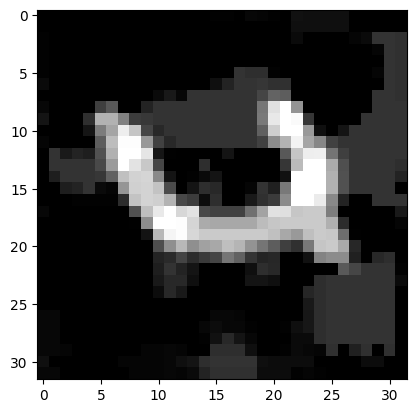

tensor([9], device='cuda:0')
tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [False,  True,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False,  True],
        [False,  True,  True,  ..., False,  True,  True],
        [False, False,  True,  ...,  True,  True,  True]], device='cuda:0')


In [337]:
images, labels = next(iter(test_loader))
index_of_4s = []
for i in range(len(labels)):
    if labels[i] == 4:
        index_of_4s.append(i)
rand_index = np.random.randint(0, len(index_of_4s))
image_norm = images[index_of_4s[rand_index]]
image_norm = image_norm[None, :, :, :]
label_adv = torch.tensor([9], device=device)
image = generate_adversarial_image(image_norm, label_adv, lr=0.01, n_steps=20, model = trained_model, device=device).cpu()
image_new = image.detach()

plot_digit(image_new[0][0])
image_new = image_new.to(device)
image_norm = image_norm.to(device)
print(torch.max(F.softmax(model(image_new), dim=1),dim=1)[1])
print(image_new[0][0] == image_norm[0][0])

In [303]:
print(image_norm.size())

torch.Size([1, 3, 32, 32])


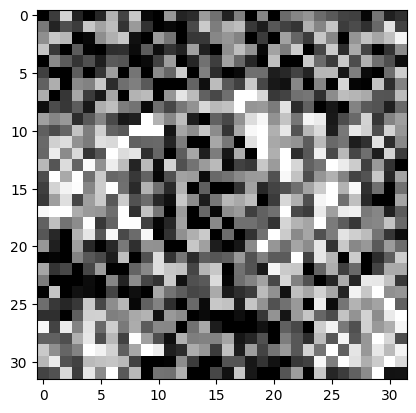

tensor([9], device='cuda:0')
tensor([[ True, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')


In [332]:
random_noise_image = torch.rand(3, 32, 32)
random_noise_image = random_noise_image[None, : , : ,:]
label_adv = torch.tensor([9], device=device)
image = generate_adversarial_image(random_noise_image, label_adv, lr=0.01, n_steps=20, model = trained_model, device=device).cpu()
image_new = image.detach()
plot_digit(image_new[0][0])
image_new = image_new.to(device)
image_norm = image_norm.to(device)
print(torch.max(F.softmax(model(image_new), dim=1),dim=1)[1])
print(image_new[0][0] == image_norm[0][0])